In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries and Modules

In [0]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from geopy.distance import great_circle
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, RandomizedSearchCV

from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE


## Loading the Datasets

In [0]:
## Loading the Datasets
train = pd.read_csv('drive/My Drive/ML/data/weka_processed/train_pro.csv')
test = pd.read_csv('drive/My Drive/ML/data/test.csv')


## Basic Intuition on the Data

In [103]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834,56,0,64,'11/1/2019 0:20','11/1/2019 0:34',6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791,47,0,134,'11/1/2019 0:56','11/1/2019 1:09',6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087,80,0,61,'11/1/2019 1:08','11/1/2019 1:26',6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598,271,15.6638,68,'11/1/2019 2:27','11/1/2019 2:37',6.92570,79.8895,6.92748,79.8971,82.3,correct
4,189128020,?,?,?,?,?,'11/1/2019 3:34','11/1/2019 3:51',6.87441,79.8615,6.84478,79.9290,358.39,correct


In [104]:
test.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,213284604,10.5,924,42,2.4486,148,2/1/2020 0:38,2/1/2020 0:53,6.83454,79.8750,6.77490,79.8840,289.27
1,213286352,10.5,4249,20,0.0000,91,2/1/2020 1:02,2/1/2020 2:13,6.91168,79.8723,6.55091,79.9706,1912.70
2,213293973,10.5,1552,255,2.6588,23,2/1/2020 5:02,2/1/2020 5:28,6.92145,79.8478,6.90539,79.8989,394.00
3,213294622,10.5,462,16,0.0000,198,2/1/2020 5:30,2/1/2020 5:38,6.77433,79.9416,6.80401,79.9407,154.32
4,213298687,10.5,814,392,12.3692,69,2/1/2020 7:00,2/1/2020 7:14,6.97968,79.9130,6.98875,79.8914,147.47


In [105]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15328 entries, 0 to 15327
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     15328 non-null  int64  
 1   additional_fare            15328 non-null  object 
 2   duration                   15328 non-null  object 
 3   meter_waiting              15328 non-null  object 
 4   meter_waiting_fare         15328 non-null  object 
 5   meter_waiting_till_pickup  15328 non-null  object 
 6   pickup_time                15328 non-null  object 
 7   drop_time                  15328 non-null  object 
 8   pick_lat                   15328 non-null  float64
 9   pick_lon                   15328 non-null  float64
 10  drop_lat                   15328 non-null  float64
 11  drop_lon                   15328 non-null  float64
 12  fare                       15328 non-null  object 
 13  label                      15328 non-null  obj

In [106]:
train.shape

(15328, 14)

In [107]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8576 entries, 0 to 8575
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     8576 non-null   int64  
 1   additional_fare            8576 non-null   float64
 2   duration                   8576 non-null   int64  
 3   meter_waiting              8576 non-null   int64  
 4   meter_waiting_fare         8576 non-null   float64
 5   meter_waiting_till_pickup  8576 non-null   int64  
 6   pickup_time                8576 non-null   object 
 7   drop_time                  8576 non-null   object 
 8   pick_lat                   8576 non-null   float64
 9   pick_lon                   8576 non-null   float64
 10  drop_lat                   8576 non-null   float64
 11  drop_lon                   8576 non-null   float64
 12  fare                       8576 non-null   float64
dtypes: float64(7), int64(4), object(2)
memory usage:

In [108]:
test.shape

(8576, 13)

## Cleaning the Data

In [0]:
## cleaning weka added unnecessary values

train = train.replace({'?': np.nan})


In [0]:
## converting label values into 0,1 instead of correct, incorrect

train.label = train.label.map(dict(correct=1, incorrect=0))

In [111]:
## check for missing values in the dataset

# train.isna().head()
train.isna().sum()

tripid                         0
additional_fare              196
duration                     196
meter_waiting                196
meter_waiting_fare           196
meter_waiting_till_pickup    196
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         133
label                          0
dtype: int64

In [112]:
test.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
dtype: int64

In [0]:
## fill missing values by mean of the column

# train.fillna(train.mean(), inplace=True)

# imputer = IterativeImputer(max_iter=10, random_state=42)
# imputer.fit(train.iloc[:,[1,2,3,4,5,12]])
# train.iloc[:,[1,2,3,4,5,12]] = imputer.transform(train.iloc[:,[1,2,3,4,5,12]])

imputer = KNNImputer(n_neighbors=5, weights='uniform')
train.iloc[:,[1,2,3,4,5,12]] = imputer.fit_transform(train.iloc[:,[1,2,3,4,5,12]])


In [114]:
train.isna().sum()

tripid                       0
additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
meter_waiting_till_pickup    0
pickup_time                  0
drop_time                    0
pick_lat                     0
pick_lon                     0
drop_lat                     0
drop_lon                     0
fare                         0
label                        0
dtype: int64

## Basic Feature Engineering

In [0]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)


## Advanced Feature Engineering

In [0]:
## new feature columns
trip_fare = []
trip_duration = []
trip_distance = []

distance_to_duration = []
fare_to_duration = []
fare_to_distance = []
waiting_fare_to_waiting_duration = []

duration_from_time = []
duration_error = []


In [0]:
## iterate through each row in the dataset
for row in dataset.itertuples():
    fare = float(row.fare)
    additional_fare = float(row.additional_fare)
    meter_waiting_fare = float(row.meter_waiting_fare)
    
    meter_waiting = row.meter_waiting
    meter_waiting_till_pickup = row.meter_waiting_till_pickup
    duration = row.duration
    
    pick_lat = row.pick_lat
    pick_lon = row.pick_lon
    drop_lat = row.drop_lat
    drop_lon = row.drop_lon
    
    pickup_time = row.pickup_time.replace('\'', '')
    drop_time = row.drop_time.replace('\'', '')
    pickup_time = pickup_time.split('/')
    drop_time = drop_time.split('/')
    
    # total fare for the trip
    cur_trip_fare = fare - (additional_fare + meter_waiting_fare)
    trip_fare.append(cur_trip_fare)
    
    # trip duration
    cur_trip_duration = duration - meter_waiting - meter_waiting_till_pickup
    trip_duration.append(cur_trip_duration)
    
    # trip distance
    cur_trip_distance = float(great_circle((drop_lat, drop_lon),(pick_lat, pick_lon)).kilometers)
    trip_distance.append(cur_trip_distance)
    
    # trip distance to duration
    try:
        cur_dist_to_dur = cur_trip_distance / cur_trip_duration
    except ZeroDivisionError:
        cur_dist_to_dur  = 0
    distance_to_duration.append(cur_dist_to_dur)
    
    # trip fare to trip duration
    try:
        cur_fare_to_duration = cur_trip_fare / cur_trip_duration
    except ZeroDivisionError:
        cur_fare_to_duration  = 0
    fare_to_duration.append(cur_fare_to_duration)
    
    # trip fare to trip distance
    try:
        cur_fare_to_distance = cur_trip_fare / cur_trip_distance
    except ZeroDivisionError:
        cur_fare_to_distance  = 0
    fare_to_distance.append(cur_fare_to_distance)
    
    # trip waiting fare to waiting duration
    try:
        cur_waiting_fare_to_waiting_dur = meter_waiting_fare / meter_waiting
    except ZeroDivisionError:
        cur_waiting_fare_to_waiting_dur  = 0
    waiting_fare_to_waiting_duration.append(cur_waiting_fare_to_waiting_dur)
    
    # time duration
    # pickup time
    month, day, y_hm = int(pickup_time[0]), int(pickup_time[1]), pickup_time[2].split(' ')
    year, h_m = int(y_hm[0]), y_hm[1].split(':')
    hour, minute = int(h_m[0]), int(h_m[1])
    pickup_time = datetime.datetime(year, month, day, hour, minute)
    
    # drop time
    month, day, y_hm = int(drop_time[0]), int(drop_time[1]), drop_time[2].split(' ')
    year, h_m = int(y_hm[0]), y_hm[1].split(':')
    hour, minute = int(h_m[0]), int(h_m[1])
    drop_time = datetime.datetime(year, month, day, hour, minute)
    
    # duration
    cur_duration_from_time = (drop_time - pickup_time).seconds
    duration_from_time.append(cur_duration_from_time)
    duration_error.append(cur_duration_from_time - duration)


In [0]:
## append new columns to dataset
dataset['trip_fare'] = trip_fare
dataset['trip_duration'] = trip_duration
dataset['trip_distance'] = trip_distance
dataset['distance_to_duration'] = distance_to_duration
dataset['fare_to_duration'] = fare_to_duration
dataset['fare_to_distance'] = fare_to_distance
dataset['waiting_fare_to_waiting_duration'] = waiting_fare_to_waiting_duration
dataset['duration_from_time'] = duration_from_time
dataset['duration_error'] = duration_error


In [0]:
## few more new features

In [0]:
## column average values
avg_fare = dataset['fare'].mean()
avg_trip_fare = dataset['trip_fare'].mean()
avg_waiting_fare = dataset['meter_waiting_fare'].mean()
avg_fare_to_distance = dataset['fare_to_distance'].mean()
avg_waiting_fare_to_duration = dataset['waiting_fare_to_waiting_duration'].mean()

In [0]:
## new columns
is_invalid_total_fare = []

div_from_avg_total_fare = []
div_from_avg_trip_fare = []
div_from_avg_waiting_fare = []

div_from_avg_fare_to_distance = []
div_from_avg_waiting_fare_to_waiting_duration = []

In [0]:
## iterate through each row in the dataset
for row in dataset.itertuples():
    fare = float(row.fare)
    trip_fare = float(row.trip_fare)
    meter_waiting_fare = float(row.meter_waiting_fare)
    additional_fare = float(row.additional_fare)
    
    fare_to_distance = float(row.fare_to_distance)
    waiting_fare_to_waiting_duration = float(row.waiting_fare_to_waiting_duration)
    
    # total fare less than or equal to zero
    if(fare-meter_waiting_fare-additional_fare <= 0):
        is_invalid_total_fare.append(1)
    else:
        is_invalid_total_fare.append(0)
        
    # diviation from average
    div_from_avg_total_fare.append(fare - avg_fare)
    div_from_avg_trip_fare.append(trip_fare - avg_trip_fare)
    div_from_avg_waiting_fare.append(meter_waiting_fare - avg_waiting_fare)
    div_from_avg_fare_to_distance.append(fare_to_distance - avg_fare_to_distance)
    div_from_avg_waiting_fare_to_waiting_duration.append(waiting_fare_to_waiting_duration - avg_waiting_fare_to_duration)


In [0]:
## append new columns to dataset
dataset['is_invalid_total_fare'] = is_invalid_total_fare
dataset['div_from_avg_total_fare'] = div_from_avg_total_fare
dataset['div_from_avg_trip_fare'] = div_from_avg_trip_fare
dataset['div_from_avg_waiting_fare'] = div_from_avg_waiting_fare
dataset['div_from_avg_fare_to_distance'] = div_from_avg_fare_to_distance
dataset['div_from_avg_waiting_fare_to_waiting_duration'] = div_from_avg_waiting_fare_to_waiting_duration


## Feature Preprocessing

In [0]:
## Scaling values into 0-1 range

scaler = MinMaxScaler(feature_range=(0,1))
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'pick_lat',
    'pick_lon',
    'drop_lat',
    'drop_lon',
    'fare',
    
    'trip_fare',
    'trip_duration',
    'trip_distance',
    'distance_to_duration',
    'fare_to_duration',
    'fare_to_distance',
    'waiting_fare_to_waiting_duration', 
    'duration_from_time',
    'duration_error',
    
    'div_from_avg_total_fare',
    'div_from_avg_trip_fare',
    'div_from_avg_waiting_fare',
    'div_from_avg_fare_to_distance',
    'div_from_avg_waiting_fare_to_waiting_duration'
]

dataset[features] = scaler.fit_transform(dataset[features])


In [0]:
## Split into training and testing again

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['label'], axis=1, inplace=True)

train['label'] = train['label'].astype(int)


In [0]:
## Drop unnecessary columns
labels_to_drop = [
    'tripid',
#     'pick_lat',
#     'pick_lon',
#     'drop_lat',
#     'drop_lon',
    'pickup_time',
    'drop_time'
]

train.drop(labels=labels_to_drop, axis=1, inplace=True)


## Feature Importance

In [127]:
y = train['label']
X = train.drop(labels=['label'], axis=1)

# apply SelectKBest class to extract top 20 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

# concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']  #naming the dataframe columns
print(featureScores.nlargest(30, 'Score'))  #print 10 best features


                                            Specs      Score
19                          is_invalid_total_fare  98.767709
3                              meter_waiting_fare  45.762684
22                      div_from_avg_waiting_fare  45.762684
2                                   meter_waiting  41.702692
17                             duration_from_time  26.762219
20                        div_from_avg_total_fare  16.324077
9                                            fare  16.324077
1                                        duration  15.017409
24  div_from_avg_waiting_fare_to_waiting_duration   9.097696
16               waiting_fare_to_waiting_duration   9.097696
6                                        pick_lon   7.468473
21                         div_from_avg_trip_fare   6.435650
10                                      trip_fare   6.435650
0                                 additional_fare   1.522733
23                  div_from_avg_fare_to_distance   1.288997
15                      

In [0]:
## Drop less important columns
labels_to_drop = [
#     'trip_duration',
#     'fare_to_duration',
#     'distance_to_duration',
    'drop_lon',
    'drop_lat',
#     'trip_distance',
#     'duration_error',
#     'pick_lat',
#     'pick_lon',
#     'meter_waiting_till_pickup',
#     'div_from_avg_fare_to_distance',
#     'fare_to_distance',
#     'additional_fare'
]

train.drop(labels=labels_to_drop, axis=1, inplace=True)


## Train for the Selected Model

In [0]:
## function to calculate F1 score
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val


In [130]:
train.shape

(15328, 24)

In [0]:
## Seperate train features and label

y = train['label']
X = train.drop(labels='label', axis=1)

# ## Spliting into training and testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [0]:
# kfold = StratifiedKFold(n_splits=20, random_state=42, shuffle=False)


In [148]:
## define the keras model
model = Sequential()

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dense(18, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1550 - get_f1: 0.9739
# Accuracy: 97.1872

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dense(12, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1517 - get_f1: 0.9754
# # Accuracy: 97.5980

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dense(18, activation='relu'))
# model.add(Dense(9, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1497 - get_f1: 0.9746
# # Accuracy: 97.6440

# model.add(Dropout(0.2, input_shape=(23,)))
# model.add(Dense(18, activation='relu'))
# model.add(Dense(9, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.2449 - get_f1: 0.9565
# # Accuracy: 95.7522

# model.add(Dense(36, input_dim=23, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(18, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(9, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1918 - get_f1: 0.9674
# # Accuracy: 97.1700

# model.add(Dense(23, input_dim=23, activation='relu'))
# model.add(Dense(12, activation='relu'))
# model.add(Dense(6, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
# # loss: 0.1568 - get_f1: 0.9736
# # Accuracy: 97.5273


model.add(Dense(36, input_dim=23, activation='relu'))
model.add(Dense(18, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# loss: 0.1519 - get_f1: 0.9747 - val_loss: 0.2556 - val_get_f1: 0.9738
# Accuracy: 97.5273


## compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_score])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 36)                864       
_________________________________________________________________
dense_45 (Dense)             (None, 18)                666       
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 152       
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 9         
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


In [0]:
# early stopping and model checkpoint
es = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=200
)

mc = ModelCheckpoint(
    filepath='drive/My Drive/ML/models/best_model.h5',
    monitor='val_accuracy',
    mode='max',
    verbose=1,
    save_best_only=True
)

In [153]:
## fit the keras model on the dataset
history = model.fit(
    X,
    y,
    epochs=1000,
    batch_size=20,
    # validation_data=(X_test, y_test),
    validation_split=0.2,
    shuffle=True,
    callbacks=[es,mc]
)


Train on 12262 samples, validate on 3066 samples
Epoch 1/1000
12262/12262 [==============================] - 2s 173us/step - loss: 0.3245 - f1_score: 0.9505 - val_loss: 0.2998 - val_f1_score: 0.9524
Epoch 2/1000
12262/12262 [==============================] - 2s 163us/step - loss: 0.2986 - f1_score: 0.9508 - val_loss: 0.3009 - val_f1_score: 0.9526
Epoch 3/1000
12262/12262 [==============================] - 2s 161us/step - loss: 0.2942 - f1_score: 0.9498 - val_loss: 0.2946 - val_f1_score: 0.9529
Epoch 4/1000
12262/12262 [==============================] - 2s 163us/step - loss: 0.2905 - f1_score: 0.9514 - val_loss: 0.2860 - val_f1_score: 0.9528
Epoch 5/1000
12262/12262 [==============================] - 2s 162us/step - loss: 0.2881 - f1_score: 0.9523 - val_loss: 0.2820 - val_f1_score: 0.9535
Epoch 6/1000
12262/12262 [==============================] - 2s 160us/step - loss: 0.2865 - f1_score: 0.9524 - val_loss: 0.2811 - val_f1_score: 0.9540
Epoch 7/1000
12262/12262 [=========================

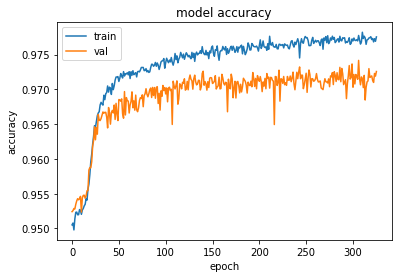

In [154]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

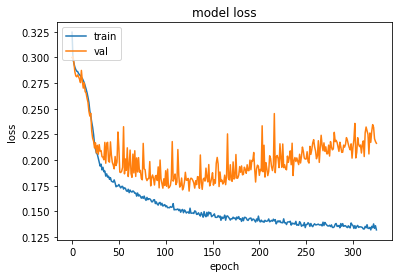

In [155]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
## load the saved best model
# saved_model = load_model('drive/My Drive/ML/models/best_model.h5')

## evaluate the keras model
# _, accuracy = model.evaluate(X_test, y_test)
# print('Accuracy: %.4f' % (accuracy * 100))


## Predicting and Preparing the Submission

In [0]:
trip_ids = test.tripid

labels_to_drop = [
    'tripid',
#     'pick_lat',
#     'pick_lon',
    'drop_lat',
    'drop_lon',
    'pickup_time',
    'drop_time',
#     'trip_distance',
#     'fare_to_duration',
#     'trip_duration',
#     'distance_to_duration',
#     'duration_error',
#     'meter_waiting_till_pickup',
#     'additional_fare'
]

test = test.drop(labels=labels_to_drop, axis=1)


In [180]:
## make probability predictions with the model
# predictions = model.predict(test)
# # round predictions
# rounded = [round(x[0]) for x in predictions]


## make class predictions with the model
predictions = model.predict_classes(test)

pred_list = []
for pred in predictions:
    pred_list.append(pred[0])

output = pd.DataFrame({'tripid': trip_ids, 'prediction': pred_list})
output.to_csv('160253h_submission_11.csv', index=False)

!cp '160253h_submission_11.csv' "drive/My Drive/ML/submissions/"

print('Completed!')


Completed!


model training.

remove outliers only (-Weka).

KNNImputer to impute missing values.

with feature engineering (added 15 new features)

datetime columns have dropped.

[model: Neural Network]

score: 0.97845
